In [70]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from hpsklearn import HyperoptEstimator
from hyperopt import tpe
from io import StringIO
from sklearn.feature_selection import chi2
from sklearn.model_selection import  train_test_split

#### Some Global Variables

In [2]:
DATA_SRC_TRAIN = '../data/train.txt'
DATA_SRC_TEST = '../data/test.txt'
DATA_SRC_VAL = '../data/val.txt'
COLUMNS = ['TEXT','CLASS']

#### Read in our data sources

In [3]:
df_train = pd.read_csv(DATA_SRC_TRAIN, sep=';',header=None)
df_test = pd.read_csv(DATA_SRC_TEST, sep=';',header=None)
df_val = pd.read_csv(DATA_SRC_VAL, sep=';',header=None)

In [4]:
print('initial train df size {}'.format(len(df_train)))
print('initial test df size {}'.format(len(df_test)))
df_train = pd.concat([df_train,df_test])
print('new train df size {}'.format(len(df_train)))

df_train.head()

initial train df size 16000
initial test df size 2000
new train df size 18000


,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


#### Add column names to the dataframe

In [5]:
df_train.columns = COLUMNS
df_val.columns = COLUMNS
df_train.head()

,TEXT,CLASS
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## EDA
#### Explore class frequencies, bigram relationships, etc.

18000


CLASS
surprise    0.035444
love        0.081278
fear        0.120056
anger       0.135222
sadness     0.291500
joy         0.336500
Name: TEXT, dtype: float64

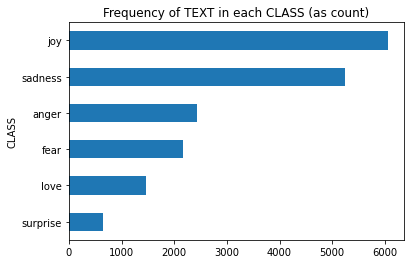

In [6]:
#training data clas frequency
df_train.groupby('CLASS').TEXT.count().sort_values().plot.barh(ylim=0,title='Frequency of TEXT in each CLASS (as count)')
#get total rows
df_all = df_train.TEXT.count()
print(df_all)
df_train.groupby('CLASS').TEXT.count().sort_values()/df_all

class imbalance exists but we will see how well models perform as is

In [7]:
#vectorize text using default TfidfVectorizer (with stopwords). Will tune later on
tfidf_train = TfidfVectorizer(stop_words = 'english')

In [8]:
#convert classes to numeric and create some mapping dict for later use
df_train['CLASS_ID'] = df_train['CLASS'].factorize()[0]
class_train_df = df_train[['CLASS','CLASS_ID']].drop_duplicates()

class_class_id_dict = dict(class_train_df.values)
class_id_class_dict = dict(class_train_df[['CLASS_ID','CLASS']].values)

In [9]:
#fit the tdfidf to transform each TEXT into a vector
train_features = tfidf_train.fit_transform(df_train['TEXT']).toarray()
train_class = df_train.CLASS_ID
print("Each of the %d complaints is represented by %d features (TF-IDF unigrams and bigrams)" %(train_features.shape))

Each of the 18000 complaints is represented by 15864 features (TF-IDF unigrams and bigrams)


In [10]:
train_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
N = 2
for CLASS, CLASS_ID in sorted(class_class_id_dict.items()):
    features_chi2 = chi2(train_features, train_class == CLASS_ID)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_train.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("n==> %s:" %(CLASS))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

C:\Users\Ahigg\PycharmProjects\EmotionsNlpStreamlit\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


n==> anger:
  * Most Correlated Unigrams are: greedy, irritable
  * Most Correlated Bigrams are: 


C:\Users\Ahigg\PycharmProjects\EmotionsNlpStreamlit\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


n==> fear:
  * Most Correlated Unigrams are: terrified, vulnerable
  * Most Correlated Bigrams are: 


C:\Users\Ahigg\PycharmProjects\EmotionsNlpStreamlit\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


n==> joy:
  * Most Correlated Unigrams are: brave, glad
  * Most Correlated Bigrams are: 


C:\Users\Ahigg\PycharmProjects\EmotionsNlpStreamlit\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


n==> love:
  * Most Correlated Unigrams are: loving, sympathetic
  * Most Correlated Bigrams are: 


C:\Users\Ahigg\PycharmProjects\EmotionsNlpStreamlit\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


n==> sadness:
  * Most Correlated Unigrams are: punished, exhausted
  * Most Correlated Bigrams are: 
n==> surprise:
  * Most Correlated Unigrams are: curious, amazed
  * Most Correlated Bigrams are: 


C:\Users\Ahigg\PycharmProjects\EmotionsNlpStreamlit\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
import sys
import os


sys.path.append(r"C:\Users\Ahigg\PycharmProjects\EmotionsNlpStreamlit")
    

In [13]:
from models import model_train
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [14]:
model_names = [LogisticRegression(),LinearSVC()]
params = [{'random_state':12, 'solver':'sag','max_iter':180},{'random_state':12}]
scoring = ['accuracy']

model_methods = model_train.ModelMethods(models=model_names,params=params,features=train_features,labels=train_class,scoring=scoring)

In [15]:
mmt = model_methods.train()

[LogisticRegression(max_iter=180, random_state=12, solver='sag'), LinearSVC(random_state=12)]


In [58]:
cv_df = pd.DataFrame(mmt, columns=['model_name', 'fold_idx', 'accuracy'])

In [59]:
import plotly.express as px

avg_acc = cv_df.groupby('model_name').accuracy.mean()

cv_df = cv_df.merge(avg_acc,on='model_name',how='left')
cv_df.columns = ['Model','K-Fold','Run Accuracy','Avg Accuracy']
fig = px.line(cv_df, x="K-Fold", y="Run Accuracy",color="Model", title='model performance across folds (training data)')

fig.show()


In [60]:
SVC = LinearSVC(random_state=25)

In [73]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(train_features, 
                                                               train_class, 
                                                               df_train.index, test_size=0.25, 
                                                               random_state=1)

In [77]:
SVC.fit(X_train,y_train.ravel())

LinearSVC(random_state=25)

In [78]:
y_pred = SVC.predict(X_test)

In [79]:
from sklearn.metrics import confusion_matrix, classification_report

In [85]:
confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred, 
                                    target_names= df_train['CLASS'].unique()))

              precision    recall  f1-score   support

     sadness       0.92      0.92      0.92      1329
       anger       0.88      0.89      0.89       623
        love       0.84      0.72      0.78       383
    surprise       0.82      0.69      0.75       173
        fear       0.84      0.84      0.84       509
         joy       0.88      0.93      0.90      1483

    accuracy                           0.88      4500
   macro avg       0.86      0.83      0.85      4500
weighted avg       0.88      0.88      0.88      4500

